### Example script for running IBS
Example 1:
We use data generated from simple discrimination orientation model and calculate its log-likelihood using IBS.
Because the analytical log-likelihood of this model is available, one can compare the results and verify the unbiasdness of the IBS estimator.

In [2]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from ibs import IBS
from psycho_gen import psycho_gen
from psycho_nll import psycho_nll

In [3]:
# Psychometric funtion model of a simple orientation discrimination task

fun = psycho_gen
Ntrials = 600
eta = np.log(1)  # Fake subject (log) sensory noise
bias = 0.2  # Fake subject response bias
lapse = 0.03  # Fake subject lapse rate
# Generating parameter vector
params = np.array([eta, bias, lapse])

# Generate stimulus orientation per trial
design_mat = 3 * npr.rand(Ntrials)
# Generate fake subject responses
resp_mat = psycho_gen(params, design_mat)

# create an ibs object and set up most of the options

# IBS object with vectorized computation
ibs = IBS(
    fun,
    resp_mat,
    design_mat,
    vectorized=True,
    acceleration=1.5,
    num_samples_per_call=0,
    max_iter=int(1e5),
    max_time=np.inf,
)
# IBS object with loop computation
ibs_loop = IBS(
    fun,
    resp_mat,
    design_mat,
    vectorized=False,
    acceleration=1.5,
    num_samples_per_call=0,
    max_iter=int(1e5),
    max_time=np.inf,
)

# Call the IBS object to compute an estimate. We can pass additional options like what additional output we want
nlogl, nlogl_var = ibs(
    params,
    num_reps=10,
    trial_weights=None,
    additional_output="var",
    return_positive=False,
)
nlogl_loop, nlogl_var_loop = ibs_loop(
    params,
    num_reps=10,
    trial_weights=None,
    additional_output="var",
    return_positive=False,
)
output = ibs(
    params,
    num_reps=10,
    trial_weights=None,
    additional_output="full",
    return_positive=False,
)


# Comparing estimated results to the true value
print("estimated negative log-likelihood", nlogl)
print("estimated variance", nlogl_var)
print("estimated negative log-likelihood (loop)", nlogl_loop)
print("estimated variance (loop)", nlogl_var_loop)
print("exact log-likelihood", psycho_nll(params, design_mat, resp_mat))
print("-------------------------------------------")
print(output)

estimated negative log-likelihood 243.73771084861622
estimated variance 18.34524740673188
estimated negative log-likelihood (loop) 236.4249864138636
estimated variance (loop) 17.745912720071857
exact log-likelihood 241.61761351081134
-------------------------------------------
                 nlogl: 241.90178413192885
             nlogl_var: 18.307143699545378
             nlogl_std: 4.27868480955835
             exit_flag: 0
               message: 'correct termination (the estimate is unbiased)'
          elapsed_time: 0.01706930000000284
 num_samples_per_trial: 1.9083333333333334
             fun_count: 8


We want to check the unbiasedness of the estimator by demonstrating that the log-likelihood estimates are centred on the true value.
For 1000 different values of the parameter theta the estimate of the log-likelihood and its standard deviation are calculated using IBS and then the standard score (z-score) of the estimate is calculated. A histogram of the z-scores is plotted. The z-scores should approximate a standard normal distribution (mean 0, SD 1).

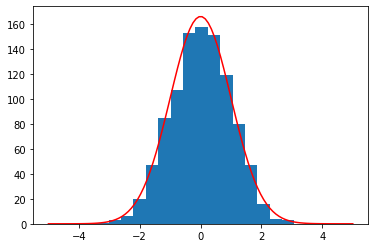

In [18]:
fun = psycho_gen
Ntrials = 600
eta = np.linspace(np.log(0.01), np.log(1), num=10)
bias = np.linspace(0.05, 0.3, num=10)
lapse = np.linspace(0.005, 0.05, num=10)
params = np.array(np.meshgrid(eta, bias, lapse)).T.reshape(-1, 3)
dmat = 3 * npr.rand(Ntrials)
Nexps = params.shape[0]
zscores = np.zeros(Nexps)

for i in range(Nexps):
    rmat = psycho_gen(params[i], dmat)
    ibs = IBS(
        fun,
        rmat,
        dmat,
        vectorized=True,
        acceleration=1.5,
        num_samples_per_call=0,
        max_iter=int(1e5),
        max_time=np.inf,
    )
    nlogl, nlogl_std = ibs(
        params[i],
        num_reps=10,
        trial_weights=None,
        additional_output="std",
        return_positive=True,
    )
    nlogl_exact = psycho_nll(params[i], dmat, rmat)
    zscores[i] = (nlogl_exact + nlogl) / nlogl_std


plt.hist(zscores, bins=16, density=False)
# plot standard normal distribution in the same graph
x = np.linspace(-5, 5, 100)
plt.plot(
    x, (Nexps * 5 / 6) * np.exp(-(x**2) / 2) / np.sqrt(2 * np.pi) / 2, color="red"
)
plt.show()

if np.abs(np.mean(zscores)) > 0.15:
    print("Warning: the mean of the z-scores is not close to zero")
if np.abs(np.std(zscores) - 1) > 0.1:
    print("Warning: the standard deviation of the z-scores is not close to one")

Example 2: Binomial Model <br>
Using IBS to compute log(p) of Bernoulli distribution with 1000 repeats. One can observe that the IBS estimates are close to the true value and calibrated.


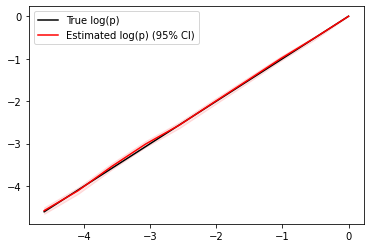

In [14]:
Nreps = 1000

# Binomial probability model
p_model = np.exp(np.linspace(np.log(0.01), np.log(1), num=10))


def fun(x, dmat):
    if dmat is None:
        return int(np.random.rand(1) < x)
    else:
        return np.vectorize(int)(np.random.rand(dmat.size) < x)


rmat = fun(1, None)
nlogl = np.zeros(len(p_model))
nlogl_std = np.zeros(len(p_model))
ibs = IBS(
    fun,
    rmat,
    None,
    vectorized=True,
    acceleration=1.5,
    num_samples_per_call=0,
    max_iter=int(1e5),
    max_time=np.inf,
)

for i in range(len(p_model)):
    nlogl[i], nlogl_std[i] = ibs(
        p_model[i],
        num_reps=Nreps,
        trial_weights=None,
        additional_output="std",
        return_positive=True,
    )

# We expect the true value to be almost certainly in this range
LL_min = nlogl - 4 * nlogl_std
LL_max = nlogl + 4 * nlogl_std
if np.any(np.log(p_model) < LL_min) or np.any(np.log(p_model) > LL_max):
    print("Warning: true value is not in the confidence interval")

plt.plot(np.log(p_model), np.log(p_model), color="black")
plt.plot(np.log(p_model), nlogl, color="red")
plt.fill_between(
    np.log(p_model),
    nlogl - 1.96 * nlogl_std,
    nlogl + 1.96 * nlogl_std,
    color="red",
    alpha=0.1,
)
plt.legend(["True log(p)", "Estimated log(p) (95% CI)"])
plt.show()

We use IBS to compute the log-likelihood of a binomial distribution with 100 trials per each of the 2000 experiments. The z-scores of each estimate are calculated. We can observe that the z-scores follow approximately a standard normal distribution (mean 0, SD 1).

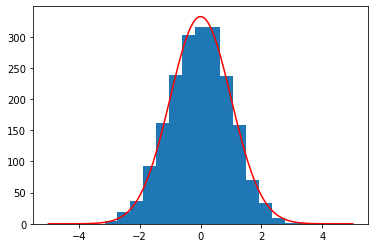

In [16]:
Ntrials = 100

# Binomial probability model
p_model = 0.9 * np.random.rand() + 0.05
p_true = 0.9 * np.random.rand() + 0.05


def fun(x, dmat):
    if dmat is None:
        return int(np.random.rand(1) < x)
    else:
        return np.random.rand(np.size(dmat)) < x


Nexps = 2 * 10**3
zscores = np.zeros(Nexps)
for i in range(Nexps):
    rmat = fun(p_true, np.zeros(Ntrials))
    ibs = IBS(
        fun,
        rmat,
        None,
        vectorized=True,
        acceleration=1.5,
        num_samples_per_call=0,
        max_iter=int(1e5),
        max_time=np.inf,
    )
    nlogl, nlogl_std = ibs(
        p_model,
        num_reps=10,
        trial_weights=None,
        additional_output="std",
        return_positive=True,
    )
    nlogl_exact = np.log(p_model) * np.sum(rmat) + np.log(1 - p_model) * np.sum(
        rmat == False
    )
    zscores[i] = (nlogl_exact - nlogl) / nlogl_std
plt.hist(zscores, bins=16, density=False)
# plot standard normal distribution in the same graph
x = np.linspace(-5, 5, 100)
plt.plot(
    x, (Nexps * 5 / 6) * np.exp(-(x**2) / 2) / np.sqrt(2 * np.pi) / 2, color="red"
)
plt.show()

if np.abs(np.mean(zscores)) > 0.15:
    print("Warning: the mean of the z-scores is not close to zero")
if np.abs(np.std(zscores) - 1) > 0.1:
    print("Warning: the standard deviation of the z-scores is not close to one")